### This notebook generates the moisture-precip relationships for MCSs in the idealized RCE simulations.

In [1]:
import numpy as np
import scipy
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from matplotlib import cm

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

# colorblind friendly colormap
CB_color_cycle = [ '#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3',
                   '#999999', '#e41a1c', '#dede00']

## Loading RCE data

In [2]:
path = '/groups/sylvia/JAS-MCS-rain/RCE-postprocessed/'
ssts = np.arange( 285, 316, 5 )

mean_280 = xr.open_dataset( path + 'RCE_COL_MEAN_280.nc' )
mean_285 = xr.open_dataset( path + 'RCE_COL_MEAN_285.nc' )
mean_290 = xr.open_dataset( path + 'RCE_COL_MEAN_290.nc' )
mean_295 = xr.open_dataset( path + 'RCE_COL_MEAN_295.nc' )
mean_300 = xr.open_dataset( path + 'RCE_COL_MEAN_300.nc' )
mean_305 = xr.open_dataset( path + 'RCE_COL_MEAN_305.nc' )
mean_310 = xr.open_dataset( path + 'RCE_COL_MEAN_310.nc' )

p99_280 = xr.open_dataset( path + 'RCE_COL_99_280.nc' )
p99_285 = xr.open_dataset( path + 'RCE_COL_99_285.nc' )
p99_290 = xr.open_dataset( path + 'RCE_COL_99_290.nc' )
p99_295 = xr.open_dataset( path + 'RCE_COL_99_295.nc' )
p99_300 = xr.open_dataset( path + 'RCE_COL_99_300.nc' )
p99_305 = xr.open_dataset( path + 'RCE_COL_99_305.nc' )
p99_310 = xr.open_dataset( path + 'RCE_COL_99_310.nc' )

### CSF-precip relationship for MCS across percentiles

In [3]:
mean_RCE = [ mean_285, mean_290, mean_295, mean_300, mean_305, mean_310 ]
p99s = [ p99_285, p99_290, p99_295, p99_300, p99_305, p99_310 ]

csf_bins_list = [ [] for i in np.arange( len(mean_RCE) ) ]
pmean_list = [ [] for i in np.arange( len(mean_RCE) ) ]
perror_list = [ [] for i in np.arange( len(mean_RCE) ) ]
p99_list = [ [] for i in np.arange( len(p99s) ) ]

m_list = [ [] for i in np.arange( len(mean_RCE) ) ]
a_list = [ [] for i in np.arange( len(mean_RCE) ) ]
m_list2 = [ [] for i in np.arange( len(mean_RCE) ) ]
a_list2 = [ [] for i in np.arange( len(mean_RCE) ) ]

In [4]:
# exponential fit between CSF and precipitation
def monoexp(x, m, a):
    return m * np.exp(a * x)

In [7]:
for iterator, array in enumerate( p99s ):
    csf_RCE = array['csf'].to_numpy()
    pmean_RCE = array['p_rate'].to_numpy()

    csf_bins, pmean_vals, _, p99_vals, _, p_error, _, _ = \
        bin_stat_function( 50, 0.25, 1, csf_RCE, pmean_RCE, threshold=10 )
    
    csf_bins_list[iterator] = csf_bins
    pmean_list[iterator] = pmean_vals
    p99_list[iterator] = p99_vals
    perror_list[iterator] = p_error
    
    # fit an exponential to the mean CSF-Precip relationship and assess goodness-of-fit
    # CSF input to the curve_fit is a decimal not a percentage, hence /100.
    p0 = [ 1, 11 ]
    i = np.where( ~np.isnan(csf_bins) )
    params, cv = scipy.optimize.curve_fit( monoexp, csf_bins[i]/100., pmean_vals[i], p0 )
    m, a = params
    m_list[iterator] = m
    a_list[iterator] = a
    
    squaredDiffs = np.square(pmean_vals[i] - monoexp(csf_bins[i]/100., m, a))
    squaredDiffsFromMean = np.square(pmean_vals[i] - np.mean(pmean_vals[i]))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    print( rSquared )
    print( str(m) + ' ' + str(a) )
    
    # fit an exponential to the max CSF-Precip relationship
    p0 = [ 1, 11 ]
    i = np.where( ~np.isnan(csf_bins) )
    params, cv = scipy.optimize.curve_fit( monoexp, csf_bins[i]/100., p99_vals[i], p0 )
    m, a = params
    m_list2[iterator] = m
    a_list2[iterator] = a
    print( str(m) + ' ' + str(a) )
    print( '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~' )

0.9948179686930883
1.6450542635074773e-11 3419.911186345889
1.0515673971021766e-07 2418.2024337046237
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.9906934942756214
2.1336088935358425e-09 2669.3307939291426
1.4468146502456834e-05 1711.376175286536
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.9956083010286898
4.3048448731921985e-09 2497.9385175398197
5.34125303805505e-06 1778.7803596718388
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.9978759386398206
1.4021014694658686e-08 2319.069961375089
4.373894705539301e-05 1526.7793415923193
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.9873381134197747
2.488783460350854e-06 1757.4445931956418
0.0002465604817032893 1332.4764214117154
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.9738781680148163
8.656247661366924e-06 1616.700064979265
0.0018677359445893045 1120.0119479785144
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


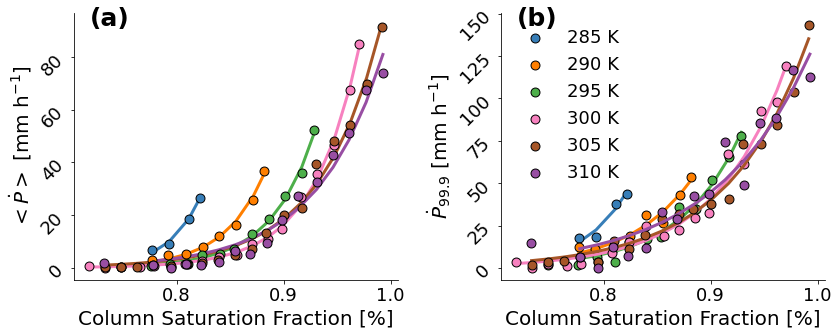

In [8]:
fig, ax = plt.subplots( 1, 2, figsize =(12, 5) )

ylab = [ r'$<\dot{P}>$ [mm h$^{-1}$]', r'$\dot{P}_{99.9}$ [mm h$^{-1}$]' ]
xlab = [ 'Column Saturation Fraction [%]', 'Column Saturation Fraction [%]' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax): 
    axis.set( ylabel = ylab[i] )
    #axis.set_xlim( [0, 100] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = xlab[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    
    if i == 0:
        for j, k, l, m, n, o in zip(csf_bins_list, pmean_list, np.arange(len(csf_bins_list)), perror_list, m_list, a_list):
            y = monoexp( j/100, n, o )
            axis.plot( j, y, lw=3, color=CB_color_cycle[l], zorder=0 )
            axis.scatter( j, k, color = CB_color_cycle[l], s=80, edgecolor='black'  )
            #axis.errorbar( j, k, xerr=None, yerr=m/2, color = CB_color_cycle[l], ls='none' )
            #axis.text( 0.05, 0.6, r'$\dot P$ = {:.2f} exp({:.2f} $\cdot$ CSF)'.format(n,o), transform=axis.transAxes, 
            #      color=CB_color_cycle[l], fontsize=15 )
        axis.text( 0.05, 0.95, '(a)', weight='bold', fontsize=25, transform=axis.transAxes )
    else:
        for j, k, l, o, p in zip(csf_bins_list, p99_list, np.arange(len(csf_bins_list)), m_list2, a_list2):
            y = monoexp( j/100, o, p )
            axis.plot( j, y, lw=3, color=CB_color_cycle[l], zorder=1 )
            axis.scatter( j, k, color = CB_color_cycle[l], s=80, edgecolor='black', label=str(ssts[l])+' K' )
        axis.legend( frameon=False )
        axis.text( 0.05, 0.95, '(b)', weight='bold', fontsize=25, transform=axis.transAxes )
            
plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-precip-RCE-percentiles.pdf', bbox_inches='tight' )
plt.show()